# Social Network Analysis Project - International Trade Flows Dataset 

In [1]:
import math
import cpnet
import certifi
import ssl
import functools
import geopy.geocoders
from geopy.geocoders import Nominatim
import pandas as pd
import pycountry
import pycountry_convert as pc
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

THRESHOLD = 1.0
PRODUCT = "GAS" #Eng, Coal, Oil, GAS, GNL
DATASET_PATH = "DatasetWithCountries.xlsx"
GRAPHS_PATH = "Graphs/"

ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx
geolocator = Nominatim(scheme='http',user_agent="SocialNetworkProject")



In [2]:
def custom_plotting_function(occurrences, xlabel, ylabel, title):
    N = 20
    occurrences = occurrences[:N]
    title=title.replace("Top", "Top "+str(N))

    _, ax = plt.subplots(figsize=(25, 10))
    plot = sns.barplot(x=0, y=1, data=occurrences, ax=ax)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.title(title, fontsize=25)
    plot.set_xticklabels(occurrences[0], rotation=45, fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.show()


### Reading and cleaning the dataset

In [3]:
df = pd.read_excel(DATASET_PATH)
df = df[df["Value (thousands USD)"] > THRESHOLD]
df['ContinentExporter'] = df['ContinentExporter'].fillna("NA")
df['ContinentImporter'] = df['ContinentImporter'].fillna("NA")

df.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
2,ALB,CZE,Eng,3382.312,EU,EU
3,ALB,GRC,Eng,41847.186,EU,EU
4,ALB,ITA,Oil,13472.550,EU,EU
5,ALB,SRB,Coal,33.708,EU,EU
6,ALB,SRB,Eng,5223.920,EU,EU


In [4]:
print("Min value: ", df["Value (thousands USD)"].min())
print("Max value: ", df["Value (thousands USD)"].max())

Min value:  1.006
Max value:  45469956.717


# Analysis based on Product 

In [5]:
df_product = df[df["Product"] == PRODUCT]
df_product.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
25,DZA,ITA,GAS,1905286.818,AF,EU
30,DZA,MAR,GAS,127993.625,AF,AF
41,DZA,ESP,GAS,1366051.869,AF,EU
89,AZE,GEO,GAS,263048.233,AS,AS
93,AZE,GRC,GAS,17041.046,AS,EU


### Find Nodes and Edges of the selected product

In [6]:
product_nodes = list(set(df_product["Exporter"].unique().tolist() + df_product["Importer"].unique().tolist()))

continent_mapping = {}
for (index, row) in df_product.iterrows():
    continent_mapping[row["Exporter"]] = row["ContinentExporter"]
    continent_mapping[row["Importer"]] = row["ContinentImporter"]

product_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_product.iterrows()]


## Creating corresponding graph

In [7]:
G_product = nx.DiGraph()

G_product.add_nodes_from(product_nodes)
for node in G_product.nodes():
    G_product.nodes[node]["Continent"] = continent_mapping[node]
    
    try:
        loc = geolocator.geocode(pycountry.countries.get(alpha_2=pc.country_alpha3_to_country_alpha2(node)).name, 
                                 country_codes=pc.country_alpha3_to_country_alpha2(node))
        
    except:
        loc = geolocator.geocode(pc.country_alpha3_to_country_alpha2(node))
    
    try:
        G_product.nodes[node]["Latitude"] = loc.latitude
        G_product.nodes[node]["Longitude"] = loc.longitude
    except:
        loc = geolocator.geocode(pc.country_alpha3_to_country_alpha2(node))
        G_product.nodes[node]["Latitude"] = loc.latitude
        G_product.nodes[node]["Longitude"] = loc.longitude

    
G_product.add_weighted_edges_from(product_edges)

inverse_weights = {}
for u, v, d in G_product.edges(data=True):
    inverse_weights[(u,v)] = math.log(d["weight"]+1)
    
nx.set_edge_attributes(G_product, inverse_weights, name="inverse_weights")


In [8]:
nx.write_graphml(G_product, GRAPHS_PATH+PRODUCT+"_graph.graphml")

In [9]:
nx.draw(G_product, with_labels=True)

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

## Degree centrality

In [ ]:
out_degree_centrality_list = sorted(nx.out_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
out_degree_centrality_list[:10]

In [ ]:
custom_plotting_function(pd.DataFrame(
    out_degree_centrality_list[:50]), "Country", "Out degree centrality", "Top countries with highest out degree centrality - " + PRODUCT)


### in degree centrality

In [ ]:
in_degree_centrality_list = sorted(nx.in_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
in_degree_centrality_list[:10]

In [ ]:
custom_plotting_function(pd.DataFrame(in_degree_centrality_list[:50]), "Country", "In degree centrality", "Top countries with highest in degree centrality - " + PRODUCT)

## Strenght Centralities

In [10]:
# Custom function to calculate the strenght centrality
def strength_centrality(G, out=True): 
    strengths = dict()
    sum_of_weights = 0
    for node in G.nodes:
        strengths[node] = 0
    for u, v, d in G.edges(data=True):
        if not out:
            k = v
            v = u
            u = k
        strengths[u] += d["weight"]
        sum_of_weights += d["weight"]
    
    for key in strengths.keys():
        strengths[key] = strengths[key] / sum_of_weights
        
    return sorted(strengths.items(), key=lambda item: item[1], reverse=True)

### Out Strenght Centralities

In [11]:
out_strengths_centrality_list = strength_centrality(G_product, out=True)
out_strengths_centrality_list[:10]

[('NOR', 0.17478154807788987),
 ('RUS', 0.16834863970850072),
 ('USA', 0.07740854507493673),
 ('TKM', 0.07664854757952357),
 ('CAN', 0.07119867361370275),
 ('BEL', 0.05187601622798548),
 ('DZA', 0.04827388890604628),
 ('MMR', 0.043051182675360185),
 ('AZE', 0.031092457755279634),
 ('BOL', 0.028230949653525943)]

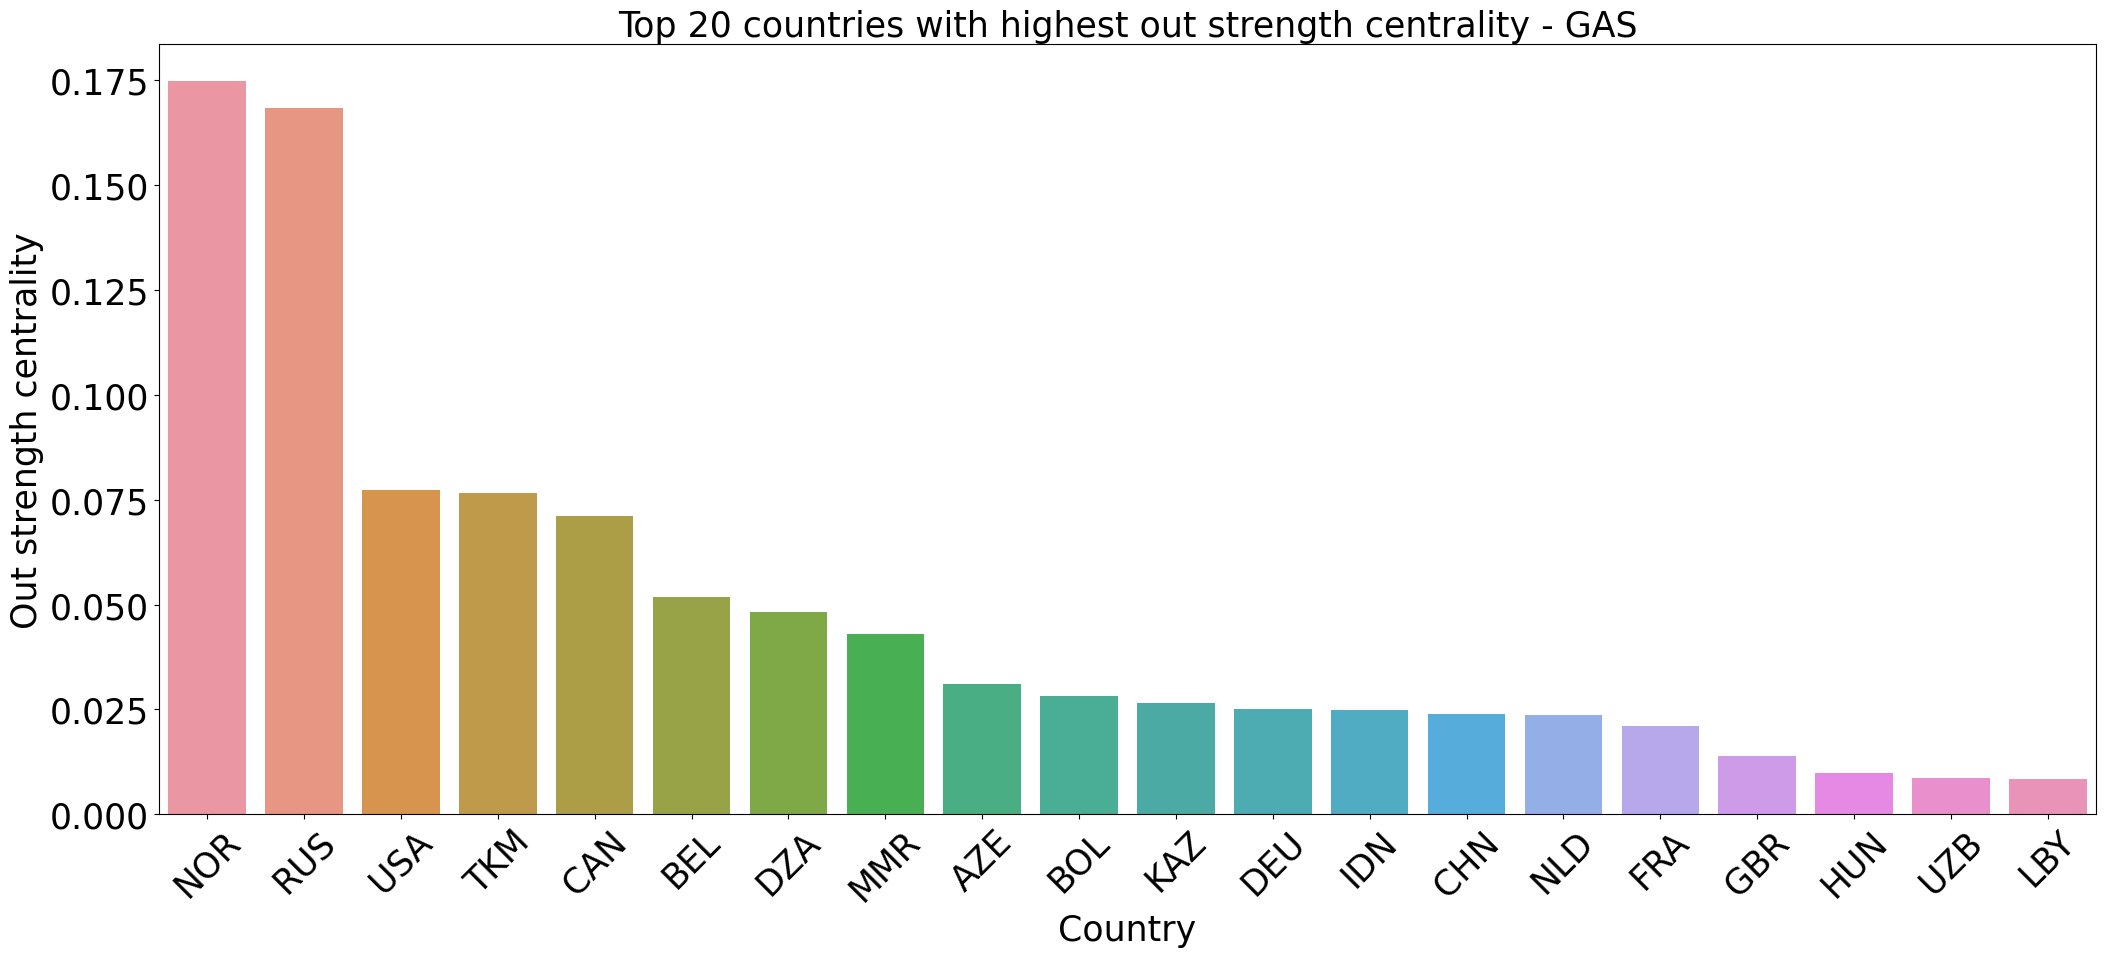

In [12]:
custom_plotting_function(pd.DataFrame(
    out_strengths_centrality_list[:50]), "Country", "Out strength centrality", "Top countries with highest out strength centrality - " + PRODUCT)


### In Strenght Centralities

In [14]:
in_strengths_centrality_list = strength_centrality(G_product, out=False)
in_strengths_centrality_list[:10]

[('CHN', 0.12853370977140308),
 ('ITA', 0.11284349811420034),
 ('DEU', 0.07639894259040908),
 ('FRA', 0.07277259898529331),
 ('USA', 0.07137043450519907),
 ('MEX', 0.05820219758619519),
 ('GBR', 0.047646373737431434),
 ('BEL', 0.04583039074922028),
 ('BLR', 0.03206149029375594),
 ('ESP', 0.027438995539371246)]

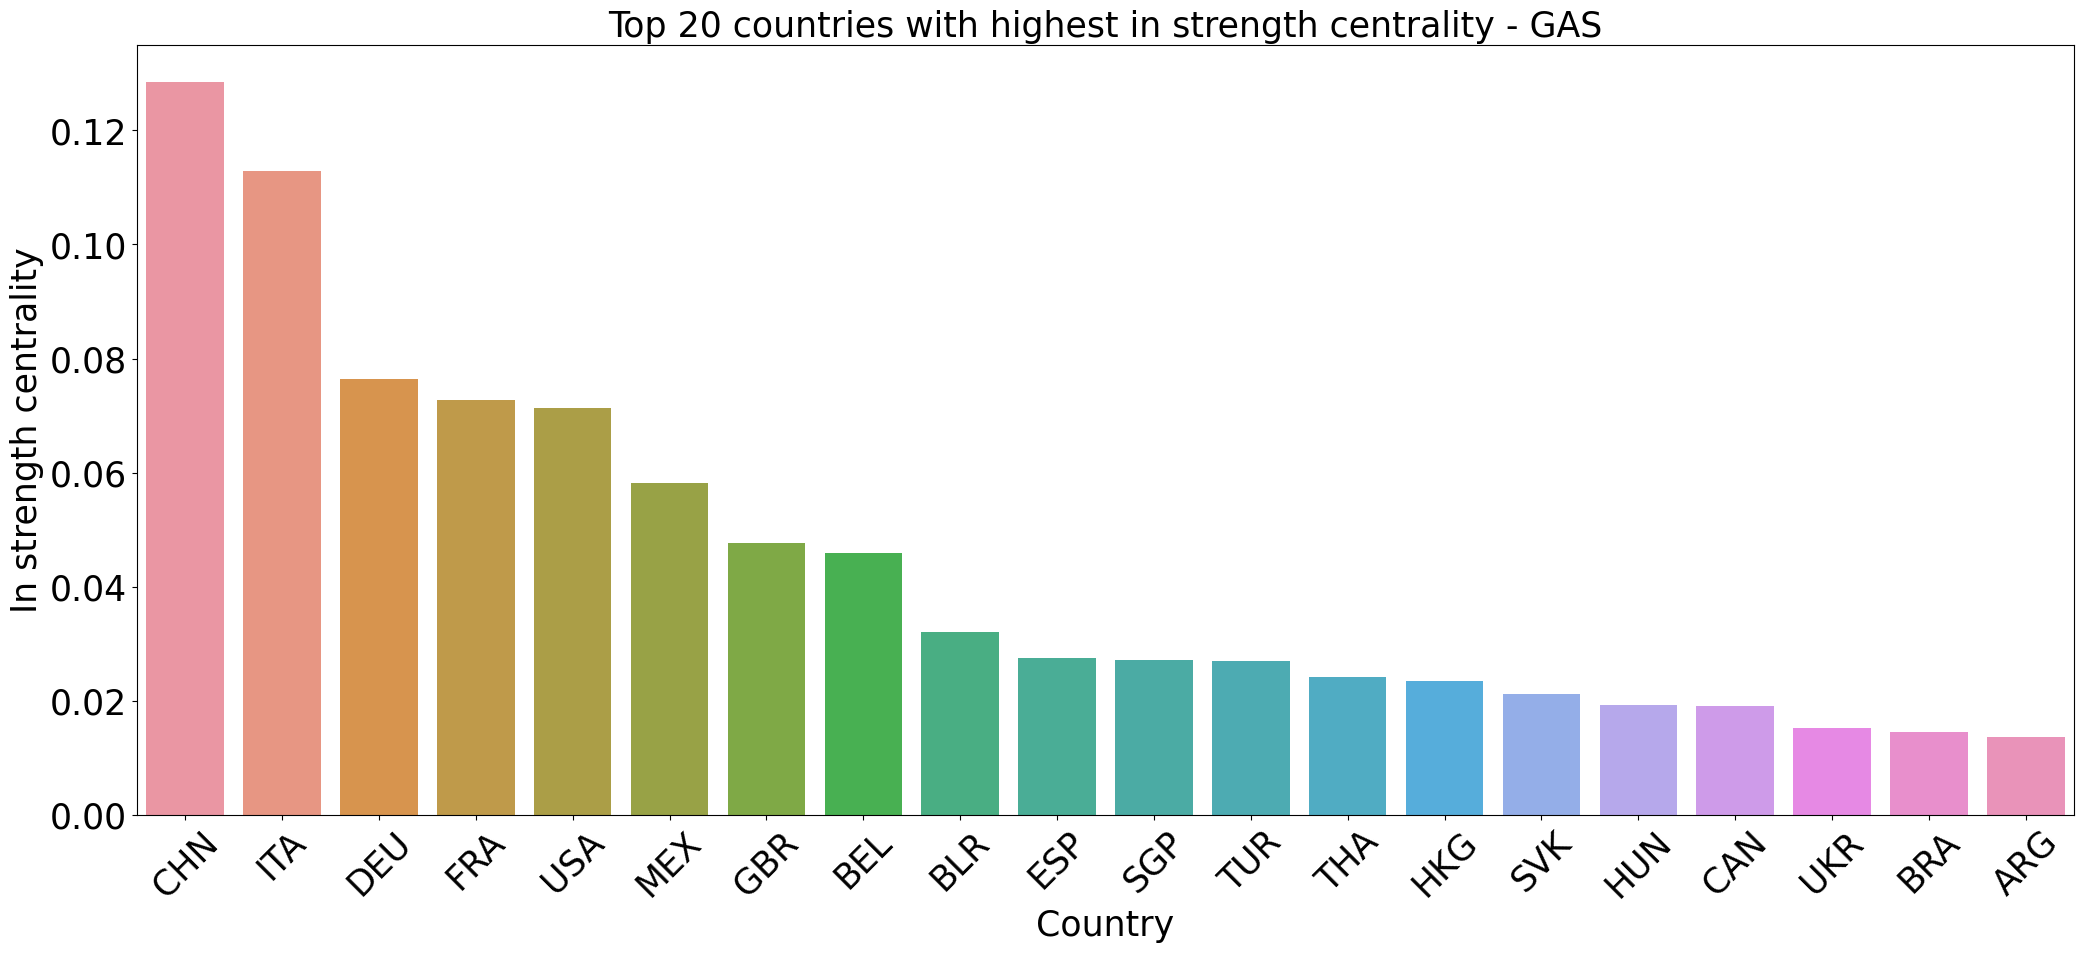

In [15]:
custom_plotting_function(pd.DataFrame(in_strengths_centrality_list[:50]), "Country", "In strength centrality", "Top countries with highest in strength centrality - " + PRODUCT)

In [17]:
print(f"out ITA: {dict(out_strengths_centrality_list)['ITA']}")
print(f"in ITA: {dict(in_strengths_centrality_list)['ITA']}")

out ITA: 0.0013221094159250476
out ITA: 0.11284349811420034


In [18]:
strength_centrality_dict = dict(in_strengths_centrality_list)
strength_centrality_dict = {node: out_strength+strength_centrality_dict[node] for node, out_strength in dict(out_strengths_centrality_list).items()}

0.11416560753012539

In [23]:
nx.set_node_attributes(G_product, dict(out_strengths_centrality_list), name="out_strength_centrality")

In [21]:
G_product.nodes["ITA"]["strength_centrality"]

0.11416560753012539

In [24]:
nx.write_graphml(G_product, GRAPHS_PATH+PRODUCT+"_graph.graphml")

## Closeness centrality

In [ ]:
closeness_centrality_list = sorted(nx.closeness_centrality(G_product, distance="inverse_weights").items(), key=lambda item: item[1], reverse=True)
closeness_centrality_list[:10]


In [ ]:
closeness_centrality_list

In [ ]:
custom_plotting_function(pd.DataFrame(closeness_centrality_list[:50]), "Country", "Closeness centrality", "Top countries with highest closeness centrality - " + PRODUCT)

## Betweeness Centrality

In [ ]:
betweenness_centrality_list = sorted(nx.betweenness_centrality(G_product, weight="inverse_weights").items(), key=lambda item: item[1], reverse=True)
betweenness_centrality_list[:10]

In [ ]:
custom_plotting_function(pd.DataFrame(betweenness_centrality_list[:50]), "Country", "Betweenness centrality", "Top countries with highest betweenness centrality - " + PRODUCT)


## Pagerank

In [ ]:
pagerank_list = sorted(nx.pagerank(G_product, weight="weight").items(), key=lambda item: item[1], reverse=True)
pagerank_list[:10]

In [ ]:
custom_plotting_function(pd.DataFrame(
    pagerank_list[:50]), "Country", "PageRank", "Top countries with highest PageRank - " + PRODUCT)


## Assortative mixing

In [ ]:
nx.attribute_assortativity_coefficient(G_product, attribute="Continent")

## Assortativity by degree

In [ ]:
nx.degree_assortativity_coefficient(G_product)

## Core-Periphery

In [ ]:
algorithm = cpnet.LapCore()
algorithm.detect(G_product)

groups = algorithm.get_pair_id()
coreness = algorithm.get_coreness()

print("Groups")
#print([(c, groups[c]) for c in groups.keys() if groups[c]!=0])
print(groups)
print()
print("Coreness=1")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==1])
print("Coreness=0")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==0])

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G_product, groups, coreness, ax)

# New graph with total flow in USD 

In [ ]:
df_total = df.groupby(['Exporter','Importer'])['Value (thousands USD)'].sum().reset_index()
df_total

In [ ]:
totalUSD_nodes = list(set(df_total["Exporter"].unique().tolist() + df_total["Importer"].unique().tolist()))

totalUSD_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_total.iterrows()]

## Create Total Graph

In [ ]:
G_total = nx.DiGraph()
G_total.add_nodes_from(totalUSD_nodes)
G_total.add_weighted_edges_from(totalUSD_edges)

In [ ]:
nx.draw_networkx(G_total,with_labels=True)

## Clustering coefficient for each node (local)

In [ ]:
local_clustering_list = sorted(nx.clustering(G_total,weight="weight").items(), key=lambda item: item[1], reverse=True)

In [ ]:
custom_plotting_function(pd.DataFrame(local_clustering_list[:50]), "Country", "Local Clustering Coeff.", "Top countries with highest Local Clustering Coefficient - " + PRODUCT)

## Average Clustering coefficient

In [ ]:
nx.average_clustering(G_total,weight="weight")

## Transitivity

In [ ]:
nx.transitivity(G_total)

## Reciprocity on the whole network

In [ ]:
nx.reciprocity(G_total)

# Create another total graph to study Cliques and Components

In [ ]:
def filter_node(n, node_list):
    if n in node_list:
        return True
    else:
        return False
    
def filter_edge(e1,e2, node_list):
    if e1 in node_list or e2 in node_list:
        return True
    else:
        return False

In [ ]:
totalValuesUSD = {}
for (index, row) in df_total.iterrows():
    totalValuesUSD[(row["Exporter"], row["Importer"])] = row["Value (thousands USD)"]

## First Approach: conservative
Here two countries A and B will have a link if and only if the flow from A to B is at least a third of the flow between B and A

In [ ]:
archsCliqueGraph_cons = []
nodesCliqueGraph_cons = []
    
for exp, imp in totalValuesUSD.keys():
    if (imp, exp) in totalValuesUSD.keys() and min(totalValuesUSD[(exp,imp)], totalValuesUSD[(imp,exp)]) > max(totalValuesUSD[(exp,imp)], totalValuesUSD[(imp,exp)]) / 3 and not (imp,exp) in archsCliqueGraph_cons:
        print(f"{exp} exports {totalValuesUSD[(exp,imp)]} to {imp}")
        print(f"{imp} exports {totalValuesUSD[(imp,exp)]} to {exp}\n")
        archsCliqueGraph_cons.append((exp, imp))
        nodesCliqueGraph_cons.append(exp)
        nodesCliqueGraph_cons.append(imp)
        
nodesCliqueGraph_cons = list(set(nodesCliqueGraph_cons))

In [ ]:
G_clique_cons = nx.Graph()

G_clique_cons.add_nodes_from(nodesCliqueGraph_cons)
G_clique_cons.add_edges_from(archsCliqueGraph_cons)

In [ ]:
nx.draw_networkx(G_clique_cons,with_labels=False)

In [ ]:
cliques_cons = list(nx.enumerate_all_cliques(G_clique_cons))
max_clique_size_cons = 0
for clique in cliques_cons:
    if len(clique) > max_clique_size_cons:
        max_clique_size_cons = len(clique)
for clique in cliques_cons:
    if len(clique) == max_clique_size_cons:
        print(clique)

In [ ]:
node_list_clique_cons = max(cliques_cons, key=len)

nx.draw_networkx(nx.subgraph_view(G_clique_cons, filter_node=functools.partial(filter_node, node_list=node_list_clique_cons), 
                                  filter_edge=functools.partial(filter_edge, node_list=node_list_clique_cons)))

And now we look for components

In [ ]:
components_cons = [component for component in sorted(nx.connected_components(G_clique_cons), key=len, reverse=False)]
maximal_comp_cons = max(components_cons, key=len)
print(f"The maximal component has size {len(maximal_comp_cons)}")
print(maximal_comp_cons)

In [ ]:
nx.draw_networkx(nx.subgraph_view(G_clique_cons, filter_node=functools.partial(filter_node, node_list=maximal_comp_cons), 
                                  filter_edge=functools.partial(filter_edge, node_list=maximal_comp_cons)), with_labels=True)

## Second approach: permissive
Here two countries A and B will have an edge if at least one exports to the other

In [ ]:
archsCliqueGraph_perm = []
nodesCliqueGraph_perm = []
    
for exp, imp in totalValuesUSD.keys():
    if  not (imp,exp) in archsCliqueGraph_perm:
        archsCliqueGraph_perm.append((exp, imp))
        nodesCliqueGraph_perm.append(exp)
        nodesCliqueGraph_perm.append(imp)
        
nodesCliqueGraph_perm = list(set(nodesCliqueGraph_perm))

In [ ]:
G_clique_perm = nx.Graph()

G_clique_perm.add_nodes_from(nodesCliqueGraph_perm)
G_clique_perm.add_edges_from(archsCliqueGraph_perm)

In [ ]:
nx.draw_networkx(G_clique_perm,with_labels=False)

Now we look for cliques

In [ ]:
cliques_perm = list(nx.enumerate_all_cliques(G_clique_perm))
max_clique_size_perm = 0
for clique in cliques_perm:
    if len(clique) > max_clique_size_perm:
        max_clique_size_perm = len(clique)
for clique in cliques_perm:
    if len(clique) == max_clique_size_perm:
        print(clique)

In [ ]:
node_list_clique_perm = max(cliques_perm, key=len)

nx.draw_networkx(nx.subgraph_view(G_clique_perm, filter_node=functools.partial(filter_node, node_list=node_list_clique_perm), 
                                  filter_edge=functools.partial(filter_edge, node_list=node_list_clique_perm)), with_labels=True)

And now we look for components

In [ ]:
components_perm = [component for component in sorted(nx.connected_components(G_clique_perm), key=len, reverse=False)]
maximal_comp_perm = max(components_perm, key=len)
print(f"The maximal component has size {len(maximal_comp_perm)}")
print(maximal_comp_perm)

In [ ]:
nx.draw_networkx(nx.subgraph_view(G_clique_perm, filter_node=functools.partial(filter_node, node_list=maximal_comp_perm), 
                                  filter_edge=functools.partial(filter_edge, node_list=maximal_comp_perm)), with_labels=True)